# Building and deploying machine learning solutions with Vertex AI: Challenge Lab

This Challenge Lab is recommended for students who have enrolled in the [**Building and deploying machine learning solutions with Vertex AI**](). You will be given a scenario and a set of tasks. Instead of following step-by-step instructions, you will use the skills learned from the labs in the quest to figure out how to complete the tasks on your own! An automated scoring system (shown on the Qwiklabs lab page) will provide feedback on whether you have completed your tasks correctly.

When you take a Challenge Lab, you will not be taught Google Cloud concepts. To build the solution to the challenge presented, use skills learned from the labs in the Quest this challenge lab is part of. You are expected to extend your learned skills and complete all tasks marked **`TODO`** in this notebook.

Are you ready for the challenge?

## Scenario

You were recently hired as a Machine Learning Engineer at a startup movie review website. Your manager has tasked you with building a machine learning model to classify the sentiment of user movie reviews as positive or negative which will be used as an input in downstream movie rating systems and to surface top supportive and critical reviews on the movie webpage. The challenge: your business requirements are that you have just 6 weeks to productionize a model that achieves great than 75% accuracy to improve upon an existing bootstrapped solution. Furthermore, after doing some exploratory analysis in your startup's data warehouse, you found that you only have a small dataset of 50k text reviews to build a higher performing solution.

To build and deploy a high performance machine learning model with limited data quickly, you will walk through training and deploying a custom TensorFlow BERT sentiment classifier for online predictions on Google Cloud's [Vertex AI](https://cloud.google.com/vertex-ai) platform. Vertex AI is Google Cloud's next generation machine learning development platform where you can leverage the latest ML pre-built components and AutoML to significantly enhance your development productivity, the ability to scale your workflow and decision making with your data, and accelerate time to value.1

![Vertex AI: Challenge Lab](./images/vertex-challenge-lab.png "Vertex Challenge Lab")

First, you will progress through a typical experimentation workflow where you will build your model from pre-trained BERT components from TF-Hub and classification layers to train and evaluate your model in a Vertex Notebook. You will then package your model code into a Docker container to train on Google Cloud using a Vertex AI CustomContainerTrainingJob. Lastly, you will define and run a Kubeflow Pipeline on Vertex Pipelines that trains and deploys your model container to a Vertex Endpoint that you will query for online predictions.

## Learning objectives

* Train a TensorFlow model locally in a hosted [**Vertex Notebook**](https://cloud.google.com/vertex-ai/docs/general/notebooks?hl=sv).
* Containerize your training code with [**Cloud Build**](https://cloud.google.com/build) and push it to [**Google Cloud Artifact Registry**](https://cloud.google.com/artifact-registry).
* Trigger a `CustomContainerTrainingJob` to train your model with the [**Vertex AI Python SDK**](https://googleapis.dev/python/aiplatform/latest/aiplatform.html).
* Define a pipeline using the [**Kubeflow Pipelines (KFP) V2 SDK**](https://www.kubeflow.org/docs/components/pipelines/sdk/v2/v2-compatibility) to train and deploy your model on [**Vertex Pipelines**](https://cloud.google.com/vertex-ai/docs/pipelines).
* Query your model on a [**Vertex Endpoint**](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) using online predictions.

## Setup

### Define constants

In [ ]:
# Add installed library dependencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

In [ ]:
# Retrieve and set PROJECT_ID and REGION environment variables.
# TODO: fill in PROJECT_ID.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1'

In [ ]:
# Create a globally unique Google Cloud Storage bucket for artifact storage.
GCS_BUCKET = f"gs://{PROJECT_ID}-vertex-challenge-lab"

In [ ]:
!gsutil mb -la $REGION $GCS_BUCKET

### Import libraries

In [ ]:
import os
import shutil
import json
import logging
from typing import NamedTuple

#
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

# Create the AdamW optimizer used in the original BERT paper.
from official.nlp import optimization  

# Libraries for data and plot model training metrics.
import pandas as pd
import matplotlib.pyplot as plt

# Import the Vertex AI Python SDK.
from google.cloud import aiplatform as vertexai

### Initialize Vertex AI Python SDK

Initialize the Vertex AI Python SDK with your GCP Project, Region, and Google Cloud Storage Bucket.

In [233]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

## Build and train your model locally in a Vertex Notebook

### Import dataset

In [341]:
DATA_URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

In [342]:
def download_data(
    data_url, 
    data_dir):
    """Download dataset.
    Args:
      data_url(str):
      data_dir(str):
    Returns:
      dataset_dir(str):
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname='aclImdb_v1.tar.gz',
      origin=data_url,
      untar=True,
      cache_dir=data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    train_dir = os.path.join(dataset_dir, 'train')
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
    
    return dataset_dir

In [ ]:
DATASET_DIR = download_data(data_url=DATA_URL, data_dir=".")

In [345]:
# Create a dictionary to iteratively add data pipeline and model training hyperparameters.
HPARAMS = {
    'seed': 42,
    'batch-size': 32
}

In [346]:
def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset):
      raw_val_ds(tf.dataset):
      raw_test_ds(tf.dataset):      
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds

In [347]:
raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, HPARAMS)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [352]:
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = raw_train_ds.class_names

train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Let's print a few example reviews:

In [353]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review {i}: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({CLASS_NAMES[label]})')

Review 0: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Label : 0 (neg)
Review 1: b"I am shocked. Shocked and dismayed that the 428 of you IMDB users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a C!. If I could give FOBH a 20, I'd gladly do it. This film ranks high atop the pantheon of modern comedy, alongside Half Baked and Mallrats, as one of the most hilarious films of all time. If you know _anything_ about rap music - YOU MUST SEE THIS!! If you know nothing about rap music - learn something!, and then see this! Comparisons to 'Spinal Tap' fail to appreciate the inspired genius of this unique film. If you liked Bob Roberts, you'll love this. Watch it and vote it a 10!"
Label : 1 (pos)
Review 2: b'What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mother 

### Choose a pre-trained BERT model to fine-tune for higher accuracy

The Small BERT models are instances of the original BERT architecture with a smaller number L of layers (i.e., residual blocks) combined with a smaller hidden size H and a matching smaller number A of attention heads, as published by

Iulia Turc, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: ["Well-Read Students Learn Better: On the Importance of Pre-training Compact Models"](https://arxiv.org/abs/1908.08962), 2019.

They have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality. For this lab, you will use a smaller model that trades accuracy for faster training times.

The following preprocessing and encoder models in the TensorFlow 2 SavedModel format use the implementation of BERT from the [TensorFlow Models Github repository on GitHub](https://github.com/tensorflow/models/tree/master/official/nlp/bert) with the trained weights released by the authors of Small BERT.

In [361]:
HPARAMS.update({
    "tfhub-bert-preprocessor": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "tfhub-bert-encoder": "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    "epochs": 5,
    "initial-learning-rate": 3e-5
})

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

For fine-tuning, you will use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate `initial-learning-rate`, you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps `n_warmup_steps`. In line with the BERT paper, the initial learning rate is smaller for fine-tuning

In [365]:
epochs = HPARAMS['epochs']
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
n_train_steps = steps_per_epoch * epochs
n_warmup_steps = int(0.1 * n_train_steps)    

OPTIMIZER = optimization.create_optimizer(init_lr=HPARAMS['initial-learning-rate'],
                                          num_train_steps=n_train_steps,
                                          num_warmup_steps=n_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


### Build and compile a TensorFlow BERT sentiment classifier

In [367]:
def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # TODO: Add a hub.KerasLayer for BERT text preprocessing.
    preprocessor = hub.KerasLayer(hparams["tfhub-bert-preprocessor"], name='preprocessing')
    encoder_inputs = preprocessor(text_input)
    # TODO: Add a hub.KerasLayer for BERT text encoding.
    encoder = hub.KerasLayer(hparams["tfhub-bert-encoder"], trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    # For the fine-tuning you are going to use the `pooled_output` array which represents each input sequence as a whole. 
    # The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
    classifier = outputs["pooled_output"]
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(0.1, name="dropout")(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    model = tf.keras.Model(text_input, classifier)
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model

In [368]:
model = build_text_classifier(HPARAMS, OPTIMIZER)

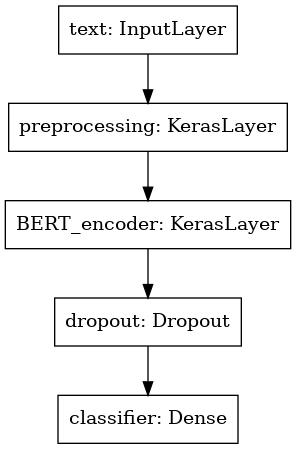

In [369]:
# Visualize your fine-tuned BERT sentiment classifier.
tf.keras.utils.plot_model(model)

In [370]:
TEST_REVIEW = ['this is such an amazing movie!']

In [371]:
BERT_RAW_RESULT = model(tf.constant(TEST_REVIEW))
print(BERT_RAW_RESULT)

tf.Tensor([[0.01045398]], shape=(1, 1), dtype=float32)


### Train and evaluate your BERT sentiment classifier

In [372]:
HPARAMS.update({
    # TODO: save your BERT sentiment classifier locally. Save it to './bert-sentiment-classifier-local'
    "model-dir": "./bert-sentiment-classifier-local"    
})

In [377]:
def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    # dataset_dir = download_data(data_url, data_dir)
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
    
    logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
history = train_evaluate(HPARAMS)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


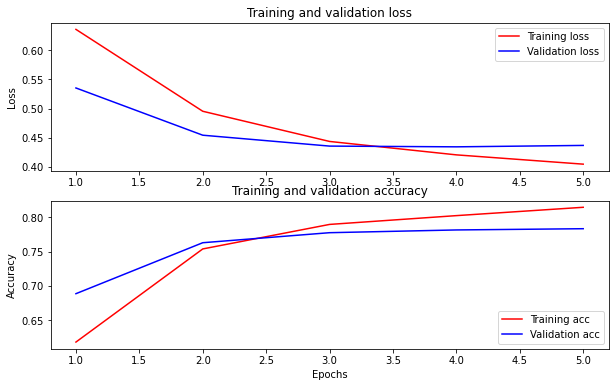

In [381]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

Now that you trained and evaluated your model locally in a Vertex Notebook as part of an experimentation workflow, your next step is to train and deploy your model on Google Cloud's Vertex AI platform.

## Containerize your model code

To train your BERT classifier on Google Cloud, you will you will package your Python training scripts and write a Dockerfile that contains instructions on your ML model code, dependencies, and execution instructions. You will build your custom container with Cloud Build, whose instructions are specified in `cloudbuild.yaml` and publish your container to your Artifact Registry. This workflow gives you the opportunity to use the same container to run as part of a portable and scalable [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) workflow. 


You will walk through creating the following project structure for your ML mode code:
```
|--/bert-sentiment-classifier
   |--/trainer
      |--__init__.py
      |--model.py
      |--task.py
   |--Dockerfile
   |--cloudbuild.yaml
   |--requirements.txt
```

### 1. Write a `model.py` training script

First, you will take tidy up your local TensorFlow model training code from above into a training script.

In [147]:
MODEL_NAME = "bert-sentiment-classifier"

In [208]:
%%writefile {MODEL_NAME}/trainer/model.py
import os
import shutil
import logging

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

DATA_URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
LOCAL_DATA_DIR = './tmp/data'
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


def download_data(data_dir):
    """Download dataset."""
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname='aclImdb_v1.tar.gz',
      origin=DATA_URL,
      untar=True,
      cache_dir=data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    train_dir = os.path.join(dataset_dir, 'train')
    
    # remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
    
    return dataset_dir


def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset):
      raw_val_ds(tf.dataset):
      raw_test_ds(tf.dataset):      
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=SEED)    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=SEED)

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds


def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessor = hub.KerasLayer(hparams['tf-hub-bert-preprocessor'], name='preprocessing')
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(hparams['tf-hub-bert-encoder'], trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    classifier = outputs["pooled_output"]
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name="dropout")(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    
    model = tf.keras.Model(text_input, classifier)   
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model


def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    dataset_dir = download_data(LOCAL_DATA_DIR)
    train_ds, val_ds, test_ds = load_datasets(dataset_dir, hparams)
    
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
        logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

Overwriting bert-sentiment-classifier/trainer/model.py


### 2. Write a `task.py` file as an entrypoint to your custom model container

In [209]:
%%writefile {MODEL_NAME}/trainer/task.py

import os
import argparse

from trainer import model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Vertex custom container training args. These are set by Vertex AI during training but can also be overwritten.
    parser.add_argument('--model-dir', dest='model-dir',
                        default=os.environ['AIP_MODEL_DIR'], type=str, help='GCS URI for saving model artifacts.') 
    parser.add_argument('--tf-hub-bert-preprocessor', dest='tf-hub-bert-preprocessor', 
                        default='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', type=str, help='TF-Hub URL.')
    parser.add_argument('--tf-hub-bert-encoder', dest='tf-hub-bert-encoder', 
                        default='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', type=str, help='TF-Hub URL.')     

    # Model training args.
    parser.add_argument('--initial-learning-rate', dest='initial-learning-rate', default=3e-5, type=float, help='Learning rate for optimizer.')
    parser.add_argument('--epochs', dest='epochs', default=5, type=int, help='Training iterations.')    
    parser.add_argument('--batch-size', dest='batch-size', default=32, type=int, help='Number of examples during each training iteration.')    
    parser.add_argument('--dropout', dest='dropout', default=0.1, type=float, help='Float percentage of DNN nodes [0,1] to drop for regularization.')    

    
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_evaluate(hparams)

Overwriting bert-sentiment-classifier/trainer/task.py


### 3. Write a `Dockerfile` for your custom model container

Third, you will write a `Dockerfile` that contains instructions to package your model code in `bert-sentiment-classifier` as well as specifies your model code's dependencies needed for execution together in a Docker container.

In [394]:
%%writefile {MODEL_NAME}/Dockerfile
# Specifies base image and tag.
# https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-5:latest
# gcr.io/deeplearning-platform-release/base-cpu

# Sets the container working directory.
WORKDIR /root

# Copies the requirements.txt into the container to reduce network calls.
COPY requirements.txt .
# Installs additional packages.
RUN pip3 install -U -r requirements.txt

# Copies the trainer code to the docker image.
COPY . /trainer

# Sets the container working directory.
WORKDIR /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]

Overwriting bert-sentiment-classifier/Dockerfile


### 4. Write a `requirements.txt` file to specify additional ML code dependencies

These are additional dependencies for your model code not included in the pre-built Vertex TensorFlow images such as TF-Hub, TensorFlow AdamW optimizer, and TensorFlow Text needed for importing and working with pre-trained TensorFlow BERT models.

In [395]:
%%writefile {MODEL_NAME}/requirements.txt
tf-models-official==2.5.0
tensorflow-text==2.5.0
tensorflow-hub==0.12.0

Overwriting bert-sentiment-classifier/requirements.txt


## Use Cloud Build to build and submit your model container to Google Cloud Artifact Registry

Next, you will use [Cloud Build](https://cloud.google.com/build) to build and upload your custom TensorFlow model container to [Google Cloud Artifact Registry](https://cloud.google.com/artifact-registry).

Cloud Build brings reusability and automation to your ML experimentation by enabling you to reliably build, test, and deploy your ML model code as part of a CI/CD workflow. Artifact Registry provides a centralized repository for you to store, manage, and secure your ML container images. This will allow you to securely share your ML work with others and reproduce experiment results.

**Note**: the initial build and submit step will take about 16 minutes but Cloud Build is able to take advantage of caching for subsequent builds.

### 1. Create Artifact Registry for custom container images

In [396]:
ARTIFACT_REGISTRY="bert-sentiment-classifier"

In [ ]:
# TODO: create a Docker Artifact Registry using the gcloud CLI. 
# Documentation link: https://cloud.google.com/sdk/gcloud/reference/artifacts/repositories/create

!gcloud artifacts repositories create $ARTIFACT_REGISTRY \
--repository-format=docker \
--location=$REGION \
--description="Artifact registry for ML custom training images for sentiment classification"

### 2. Create `cloudbuild.yaml` instructions

In [398]:
IMAGE_NAME="bert-sentiment-classifier"
IMAGE_TAG="latest"
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY}/{IMAGE_NAME}:{IMAGE_TAG}"

In [399]:
cloudbuild_yaml = f"""steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', '{IMAGE_URI}', '.' ]
images: 
- '{IMAGE_URI}'"""

with open(f"{MODEL_NAME}/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

### 3. Build and submit your container image to Artifact Registry using Cloud Build

In [ ]:
# TODO: use Cloud Build to build and submit your custom model container to your Artifact Registry.
# Documentation link: https://cloud.google.com/sdk/gcloud/reference/builds/submit
# Hint: make sure the config flag is pointed at {MODEL_DIR}/cloudbuild.yaml defined above and you include your model directory.

!gcloud builds submit {MODEL_NAME} --timeout=20m --config {MODEL_NAME}/cloudbuild.yaml

## Trigger a `CustomContainerTrainingJob` to train your model using the Vertex AI Python SDK

Use the `CustomTrainingJob` class to define the job, which takes the following parameters specific to custom container training in the constructor:

* `display_name`: You user-defined name of this training pipeline.
* `container_uri`: The URI of your custom training container image.
* `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model. You will use a Vertex prebuilt container.

Use the `run()` function to start training, which takes the following parameters:

* `replica_count`: The number of worker replicas.
* `machine_type`: The type of machine to use for training.

The run function creates a training pipeline that trains and creates a Vertex `Model` object. After the training pipeline completes, the `run()` function returns the `Model` object below.

Note: this `CustomContainerTrainingJob` will take about 20 minutes to provision resources and train your model.

In [504]:
import datetime

TIMESTAMP=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
DISPLAY_NAME = "bert-sentiment-{}".format(TIMESTAMP)
GCS_BASE_OUTPUT_DIR= f"{GCS_BUCKET}/{MODEL_NAME}-{TIMESTAMP}"

print(DISPLAY_NAME)
print(GCS_BASE_OUTPUT_DIR)

bert-sentiment-20211010164052
gs://dougkelly-vertex-demos-vertex-challenge-lab/bert-sentiment-classifier-20211010164052


In [505]:
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-5:latest'

In [ ]:
#TODO: complete code in the training job constructor and run arguments below.
# Required: include display_name, container_uri, and model_serving_container_image_uri
job = vertexai.CustomContainerTrainingJob(
    display_name=MODEL_NAME,
    container_uri=IMAGE_URI, 
    model_serving_container_image_uri=SERVING_IMAGE_URI,

)

model = job.run(
    # GCS custom job output dir.
    base_output_dir=GCS_BASE_OUTPUT_DIR,
    # Custom job WorkerPool arguments.
    replica_count=1,
    machine_type="c2-standard-4",
)

In [515]:
model.gca_resource.name

'projects/617979904441/locations/us-central1/models/547037821144137728'

In [ ]:
model.deploy()

## Define a `CustomContainerTrainingJobRunOp` component

In [574]:
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import dsl
from kfp.components import create_component_from_func
from kfp.v2.dsl import (ClassificationMetrics, Input, Metrics, Model, Output,
                        component)

In [585]:
@component(
    base_image="python:3.7",
    output_component_file="CustomContainerTrainEvaluateOp.yaml",
    packages_to_install=["google-cloud-aiplatform==1.5.0"])
def CustomContainerTrainEvaluateOp(
    project: str,
    location: str,
    container_uri: str,
    display_name: str, 
    staging_bucket: str,
    gcs_base_output_dir: str,   
    serving_container_uri: str,
) -> NamedTuple("Outputs", [("model", Model)]):
    """
    Args:
    Returns:
    """
    from google.cloud import aiplatform as vertexai
    
    vertexai.init(project=project,
                  location=location,
                  staging_bucket=staging_bucket)
    
    job = vertexai.CustomContainerTrainingJob(
        display_name=display_name,
        container_uri=container_uri,
        staging_bucket=staging_bucket,
        model_serving_container_image_uri=serving_container_uri
    )
    
    model = job.run(
        # GCS custom job output dir.
        base_output_dir=gcs_base_output_dir,
        # Custom job WorkerPool arguments.
        replica_count=1,
        machine_type="c2-standard-4",
    )
    
    return (model,)

In [576]:
# CustomContainerTrainEvaluateOp = create_component_from_func(
#     func=CustomContainerTrainEvaluateOp,
#     base_image="python:3.7", 
#     output_component_file="CustomContainerTrainEvaluateOp.yaml",
#     packages_to_install=["google-cloud-aiplatform==1.5.0"])

## Define a pipeline using the KFP V2 SDK

In [586]:
TIMESTAMP=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
DISPLAY_NAME = "bert-sentiment-{}".format(TIMESTAMP)
GCS_BASE_OUTPUT_DIR= f"{GCS_BUCKET}/{MODEL_NAME}-{TIMESTAMP}"

print(DISPLAY_NAME)
print(GCS_BASE_OUTPUT_DIR)

bert-sentiment-20211010210457
gs://dougkelly-vertex-demos-vertex-challenge-lab/bert-sentiment-classifier-20211010210457


In [587]:
USER = "dougkelly"  # <---CHANGE THIS
PIPELINE_ROOT = "{}/pipeline_root/{}".format(GCS_BUCKET, USER)

PIPELINE_ROOT

'gs://dougkelly-vertex-demos-vertex-challenge-lab/pipeline_root/dougkelly'

In [588]:
@dsl.pipeline(name="bert-sentiment-classification", pipeline_root=PIPELINE_ROOT)
def pipeline(
    project: str = PROJECT_ID,
    location: str = REGION,
    container_uri: str = IMAGE_URI,
    display_name: str = DISPLAY_NAME,
    staging_bucket: str = GCS_BUCKET,
    gcs_base_output_dir: str = GCS_BASE_OUTPUT_DIR,    
    model_serving_container_uri: str = SERVING_IMAGE_URI
):
    
    #TODO: add and configure CustomerContainerTrainingJobRunOp component from above.
    # Hint: the arguments will be the same as the CustomContainerTrainingJob earlier.
    # model_train_evaluate_op = gcc_aip.CustomContainerTrainingJobRunOp(
    #     display_name=display_name,
    #     container_uri=container_uri,
    #     model_serving_container_image_uri=model_serving_container_uri,
    #     base_output_dir=gcs_base_output_dir,
    #     # Custom job WorkerPool arguments.
    #     replica_count=1,
    #     machine_type="c2-standard-4",        
    # )
    
    # Custom custom container component
    model_train_evaluate_op = CustomContainerTrainEvaluateOp(
        project=project,
        location=location,
        container_uri=container_uri,
        display_name=display_name, 
        staging_bucket=staging_bucket,
        gcs_base_output_dir=gcs_base_output_dir,
        serving_container_uri=model_serving_container_uri,
    )
    
    
#     model_upload_op = gcc_aip.ModelUploadOp(
#         display_name=display_name,
#         artifact_uri=
#     )
    
#     model_upload_op.after(model_train_evaluate_op)
    
    
    # Pre-built Google Cloud KFP component
    model_deploy_op = gcc_aip.ModelDeployOp(
        model=model_train_evaluate_op.outputs["model"],
        project=project,
        location=location,
        machine_type="n1-standard-4",
    )

## Compile the pipeline

In [589]:
from kfp.v2 import compiler

In [590]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="bert-sentiment-classification.json"
)

## Run the pipeline on Vertex Pipelines

In [591]:
vertex_pipelines_job = vertexai.pipeline_jobs.PipelineJob(
    display_name="bert-sentiment-classification",
    template_path="bert-sentiment-classification.json",
    parameter_values={
        "project": PROJECT_ID,
        "location": REGION,
        "container_uri": IMAGE_URI,
        "display_name": DISPLAY_NAME,
        "staging_bucket": GCS_BUCKET,
        "gcs_base_output_dir": GCS_BASE_OUTPUT_DIR,
        "model_serving_container_uri": SERVING_IMAGE_URI},
    enable_caching=True,
)

In [592]:
vertex_pipelines_job.run()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/617979904441/locations/us-central1/pipelineJobs/bert-sentiment-classification-20211010210501
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/617979904441/locations/us-central1/pipelineJobs/bert-sentiment-classification-20211010210501')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/bert-sentiment-classification-20211010210501?project=617979904441
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/617979904441/locations/us-central1/pipelineJobs/bert-sentiment-classification-20211010210501 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projec

RuntimeError: Job failed with:
code: 9
message: "The DAG failed because some tasks failed. The failed tasks are: [model-deploy].; Job (project_id = dougkelly-vertex-demos, job_id = 3102601911258316800) is failed due to the above error.; Failed to handle the job: {project_number = 617979904441, job_id = 3102601911258316800}"


## Query deployed model on Vertex Endpoint for online predictions

Finally, you will retrieve the `Endpoint` deployed by the pipeline and use it to query your model for online predictions below.

In [ ]:
ENDPOINT_NAME = vertexai.Endpoint.list()[0].name

In [ ]:
endpoint = vertexai.Endpoint(
    endpoint_name=ENDPOINT_NAME,
    project=PROJECT_ID,
    location=REGION)

In [ ]:
#TODO: Generate online predictions using your Vertex Endpoint.
"test random review"

## Next steps

Congratulations! You walked through a full experimentation, containerization, and MLOps workflow on Vertex AI. First, you built, trained, and evaluated a BERT sentiment classifier model in a Vertex Notebook. You then packaged your model code into a Docker container to train on Google Cloud using a Vertex AI CustomContainerTrainingJob. Lastly, you defined and ran a Kubeflow Pipeline on Vertex Pipelines that trained and deployed your model container to a Vertex Endpoint that you queried for online predictions.

## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.